#Lab6 - Dataloaders - Assigment's instructions:
![image](https://user-images.githubusercontent.com/55464049/113273469-5966af80-92e5-11eb-9b1c-f06076a1f377.png)

[PyTorch docs](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html#developing-custom-pytorch-dataloaders)

[Albumentation docs](https://albumentations.ai/docs/getting_started/image_augmentation/)

![image](https://user-images.githubusercontent.com/55464049/113273501-62578100-92e5-11eb-879c-b2c96be78959.png)


In [ ]:
%matplotlib inline

# 1.  [PyTorch datasets:](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html#developing-custom-pytorch-dataloaders)
__TL;DR__ 
PyTorch's dataset tool is pytorch's way to efficiantly and simply use use the data in our projects. 
First, it provides us users with a way to create and implement our own data-sets by instructing us how to build a class [ Interface ] that will work with they're model, (len, get_item).
It also provides us with a better way to implement augmentation on-the-fly while importing the photos. 

__DataLoader__ tool provides us with a simple-to-use very useful features: 
-  Batching the data - [ instead of itering one by one ] 
-  Shuffling the data 
-  Load the data in parallel using ``multiprocessing`` workers. [ load data fast ]

[Demo Video](https://www.youtube.com/watch?v=PXOzkkB5eH0&ab_channel=PythonEngineer)







# 2. [Albumentation Augmentations:](https://albumentations.ai/docs/getting_started/image_augmentation/)

## TL;DR:
Our main goal is the create a pipeline which will read the images from the disk, implement the neccessary augmentations, and automatically bring augmented image into the process. The class 'compose' represents the pipeline. Compose gets in it's constructor a list of augmentations*, and applys them one by one over the incoming images.
* each augmenatation has it's own parameters, and a probability of which the augmentation itself will by applied on the incoming photo.


In [ ]:

# 1 2 3 4 5 6 7 8 9

# 3. Implement Albumentation's augmentations

In [2]:
# import Albumentation:
import albumentations as A
# import mnist 
from keras.datasets import mnist 
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

In [4]:
# define pipeline: 
# define pipeline: # 2 0 5 9 3 6 8 0 0 ----- > 3 6 8  
transform = A.Compose([ 
    A.Flip(p = 0.8),
    A.Rotate(p = 0.6),
    A.Blur(p = 0.3),
])


____ ( IN LAB ITSELF ) ____

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, train_set, transofrms=None):
        super (MNISTDataset, self).__init__()
        self.x_train = train_set.data
        self.y_train = train_set.targets
        self.transofrm = transforms

    def __getitem__(self,idx):
        assert isinstance(idx, (int))
        sample = {'image': x_train[idx], 'label:'y_train[idx]}
        return sample # dictionary image - label
        #my code

    def __len__(self):
        return len(self.x_train)

--------------------------
--------------------------
--------------------------
-----Pytorch Example:------
--------------------------
--------------------------
--------------------------

## Developing Custom PyTorch Dataloaders
=====================================

A significant amount of the effort applied to developing machine
learning algorithms is related to data preparation. PyTorch provides
many tools to make data loading easy and hopefully, makes your code more
readable. In this recipe, you will learn how to:

 1. Create a custom dataset leveraging the PyTorch dataset APIs;
 2. Create callable custom transforms that can be composable; and
 3. Put these components together to create a custom dataloader.

Please note, to run this tutorial, ensure the following packages are
installed:
 -  ``scikit-image``: For image io and transforms
 -  ``pandas``: For easier csv parsing

As a point of attribution, this recipe is based on the original tutorial
from `Sasank Chilamkurthy <https://chsasank.github.io>`__ and was later
edited by `Joe Spisak <https://github.com/jspisak>`__.



### Setup
----------------------
First let’s import all of the needed libraries for this recipe.





In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

### Part 1: The Dataset
-------------------




The dataset we are going to deal with is that of facial pose. Overall,
68 different landmark points are annotated for each face.

As a next step, please download the dataset from
`here <https://download.pytorch.org/tutorial/faces.zip>`_ so that the
images are in a directory named ‘data/faces/’.

**Note:** This dataset was actually generated by applying
`dlib's pose estimation <https://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_
on images from the imagenet dataset containing the ‘face’ tag.





In [ ]:
!wget https://download.pytorch.org/tutorial/faces.zip
!mkdir data/faces/
import zipfile
with zipfile.ZipFile("faces.zip","r") as zip_ref:
    zip_ref.extractall("/data/faces/")
    %cd /data/faces/

--2021-04-03 15:05:17--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.98, 13.226.50.24, 13.226.50.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M  24.5MB/s    in 0.2s    

2021-04-03 15:05:17 (24.5 MB/s) - ‘faces.zip’ saved [5780252/5780252]

mkdir: cannot create directory ‘data/faces/’: No such file or directory
/data/faces


The dataset comes with a csv file with annotations which looks like
this:

image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312


Let’s quickly read the CSV and get the annotations in an (N, 2) array
where N is the number of landmarks.




In [ ]:
# import the dataset from CSV
landmarks_frame = pd.read_csv('faces/face_landmarks.csv') # the entire database
display(landmarks_frame)

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,220,89,238,108,255,129,268,155,268,180,261,203,244,222,224,238,199,247,172,248,144,245,116,241,87,39,114,45,102,57,...,98,207,107,199,120,193,131,193,142,188,162,185,184,187,168,206,151,218,139,222,127,223,113,219,103,206,122,203,133,201,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,536,186,567,214,594,249,614,290,616,329,608,363,589,390,562,411,529,421,491,425,450,425,409,423,370,162,345,178,330,200,...,228,514,246,502,264,495,278,499,292,495,315,502,341,511,318,530,297,538,281,539,266,537,248,529,239,513,265,507,278,509,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,238,103,257,117,274,134,287,154,290,176,287,197,276,218,263,235,247,246,227,251,205,253,181,254,157,91,136,98,127,112,...,116,224,127,221,140,221,149,223,160,220,177,220,195,224,179,238,163,244,152,245,141,244,129,239,120,225,140,225,150,226,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,107,41,116,50,122,61,126,72,127,83,126,95,123,107,119,115,111,118,101,120,91,122,80,122,68,39,52,45,46,53,...,55,98,63,96,70,94,75,95,80,94,86,95,94,99,86,103,79,105,74,105,69,105,62,103,58,99,70,98,74,98,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,121,91,129,98,136,106,142,115,144,125,142,134,137,142,130,149,122,153,113,154,102,155,91,156,79,84,75,87,71,93,...,96,114,102,112,109,112,114,114,119,112,126,112,134,113,127,122,120,126,114,126,109,126,102,122,99,115,109,115,114,116,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,134,54,142,61,148,70,152,80,154,90,153,99,149,107,143,113,135,117,126,119,115,121,104,122,93,49,83,54,79,60,...,66,130,72,127,77,125,81,126,85,125,90,127,96,130,90,132,85,134,81,134,77,133,71,133,68,130,77,130,81,130,85,130,94,130,85,128,81,12

In [ ]:
# iloc - when doin iloc with group of indexes, it returns sub-group of the data that assembled from the indexes
# .iloc[] - select columns and rows in data-frames

n = 65 # number of landmarks over an image.
img_name = landmarks_frame.iloc[n, 0] # get all the columns but only row 0 ()
landmarks = landmarks_frame.iloc[n, 1:] #
landmarks = np.asarray(landmarks) #
landmarks = landmarks.astype('float').reshape(-1, 2) #

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}\n '.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]
 


#### 1.1 Write a simple helper function to show an image
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Next let’s write a simple helper function to show an image, its landmarks and use it to show a sample.





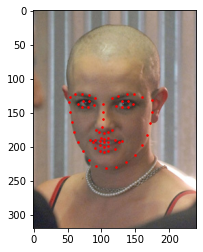

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

#### 1.2 Create a dataset class
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Now lets talk about the PyTorch dataset class





``torch.utils.data.Dataset`` is an abstract class representing a
dataset. Your custom dataset should inherit ``Dataset`` and override the
following methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support indexing such that ``dataset[i]`` can be
   used to get $`i$` th sample

Let’s create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Here we show a sample of our dataset in the forma of a dict
``{'image': image, 'landmarks': landmarks}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in
another recipe.




In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

#### 1.3 Iterate through data samples
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




Next let’s instantiate this class and iterate through the data samples.
We will print the sizes of first 4 samples and show their landmarks.




0 (324, 215, 3) (68, 2)


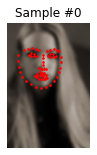

1 (500, 333, 3) (68, 2)


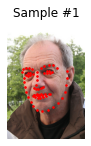

2 (250, 258, 3) (68, 2)


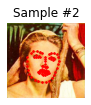

3 (434, 290, 3) (68, 2)


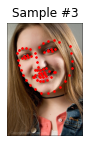

In [ ]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### Part 2: Data Tranformations
---------------------------




Now that we have a dataset to work with and have done some level of
customization, we can move to creating custom transformations. In
computer vision, these come in handy to help generalize algorithms and
improve accuracy. A suite of transformations used at training time is
typically referred to as data augmentation and is a common practice for
modern model development.

One issue common in handling datasets is that the samples may not all be
the same size. Most neural networks expect the images of a fixed size.
Therefore, we will need to write some prepocessing code. Let’s create
three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it’s
called. For this, we just need to implement ``__call__`` method and if
required, ``__init__`` method. We can then use a transform like this:

::

   tsfm = Transform(params)
   transformed_sample = tsfm(sample)

Observe below how these transforms had to be applied both on the image
and landmarks.




#### 2.1 Create callable classes
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Let’s start with creating callable classes for each transform





In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

#### 2.2 Compose transforms and apply to a sample
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Next let’s compose these transforms and apply to a sample


Let’s say we want to rescale the shorter side of the image to 256 and
then randomly crop a square of size 224 from it. i.e, we want to compose
``Rescale`` and ``RandomCrop`` transforms.
``torchvision.transforms.Compose`` is a simple callable class which
allows us to do this.




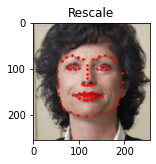

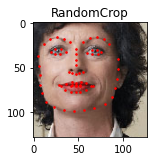

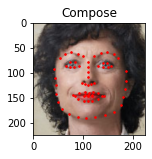

In [ ]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

#### 2.3 Iterate through the dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Next we will iterate through the dataset


Let’s put this all together to create a dataset with composed
transforms. To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range`` loop
as before.




In [ ]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


### Part 3: The Dataloader
----------------------




By operating on the dataset directly, we are losing out on a lot of
features by using a simple ``for`` loop to iterate over the data. In
particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.




0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


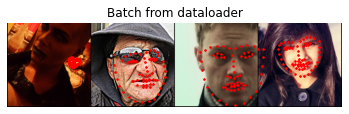

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

Now that you’ve learned how to create a custom dataloader with PyTorch,
we recommend diving deeper into the docs and customizing your workflow
even further. You can learn more in the ``torch.utils.data`` docs
`here <https://pytorch.org/docs/stable/data.html>`__.

____________________________________



-----------------------------



In [ ]:
%%shell

jupyter nbconvert --to html /content/CV2021Bipynb